# Activity Recognition (Many to One)
On this notebook we will learn how to classify a sequence of X/Y/Z accelerometer data into one of the following 6 classes:
* Walking
* Jogging
* Upstairs
* Downstairs
* Sitting
* Standing

### RNN Introduction
RNN Networks are made of RNN cells whose outputs depends on some input signal and some internal state. The RNN networks are formed in a way that one cell feed it's internal state to the next one. The only exception is the first cell that has a vector of zeros as internal state.
![alt text](imgs/RNN.png "Types")

#### RNN Cell
The RNN Cell has 1 inputs, one for the input signal, and one internal state that will be populated with a previous result of the Cell.
The RNN cell behaviour can be expressed with the following formula:
$$h_t = \tanh ( W_{h} h_{t-1} + W_{x} x_t )$$

#### Problems with RNN
The main issue with simple RNN's is that their model cant handle very big sequences, due to an issue called vanishing gradient. To remedy this other cell structures (ie: LSTM, GRUs) uses internal gates.

### Recurrent Networks Structures
RNN networks can be configured on the following structures:
* One-to-one: Normal Feed-Forward Neural Networks
* One-to-Many: Text/Music generation
* Many-to-One: Sentiment Analysis, Text Classification, Human-Activity-Recognition
* Many-to-Many: Machine translation
![alt text](imgs/sequnce_types.png "Types")


Example of Human Activity Recognition with LSTM network configured many-to-one.

### References
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
* https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/home
* https://github.com/curiousily/TensorFlow-on-Android-for-Human-Activity-Recognition-with-LSTMs
* https://medium.com/@curiousily/human-activity-recognition-using-lstms-on-android-tensorflow-for-hackers-part-vi-492da5adef64
* http://cs229.stanford.edu/proj2017/final-reports/5219166.pdf
* https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb
* https://notebooks.azure.com/goldengrape/projects/pytorch-tutorial/html/tutorials/02-intermediate/recurrent_neural_network/main-gpu.py
* https://github.com/bentrevett/pytorch-sentiment-analysis
* https://discuss.pytorch.org/t/example-of-many-to-one-lstm/1728
* https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218
* https://medium.com/@florijan.stamenkovic_99541/rnn-language-modelling-with-pytorch-packed-batching-and-tied-weights-9d8952db35a9
* https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
* https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
* https://github.com/pangolulu/rnn-from-scratch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from pylab import rcParams

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

seq_size = 200
N_FEATURES = 3
N_EPOCHS = 50
BATCH_SIZE = 1024
num_classes=6

### Read Dataset

In [2]:
df = pd.read_pickle('data/WISDM_ar_v1.1_raw.pickle')
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


### Clean Nan from Data

In [3]:
df = df.dropna()

### Plot some Information

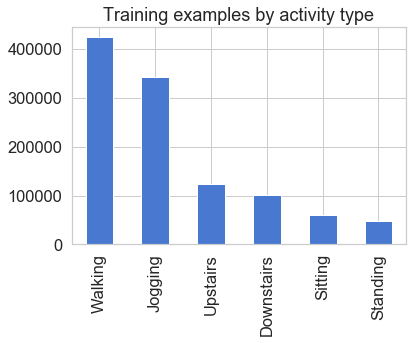

In [4]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

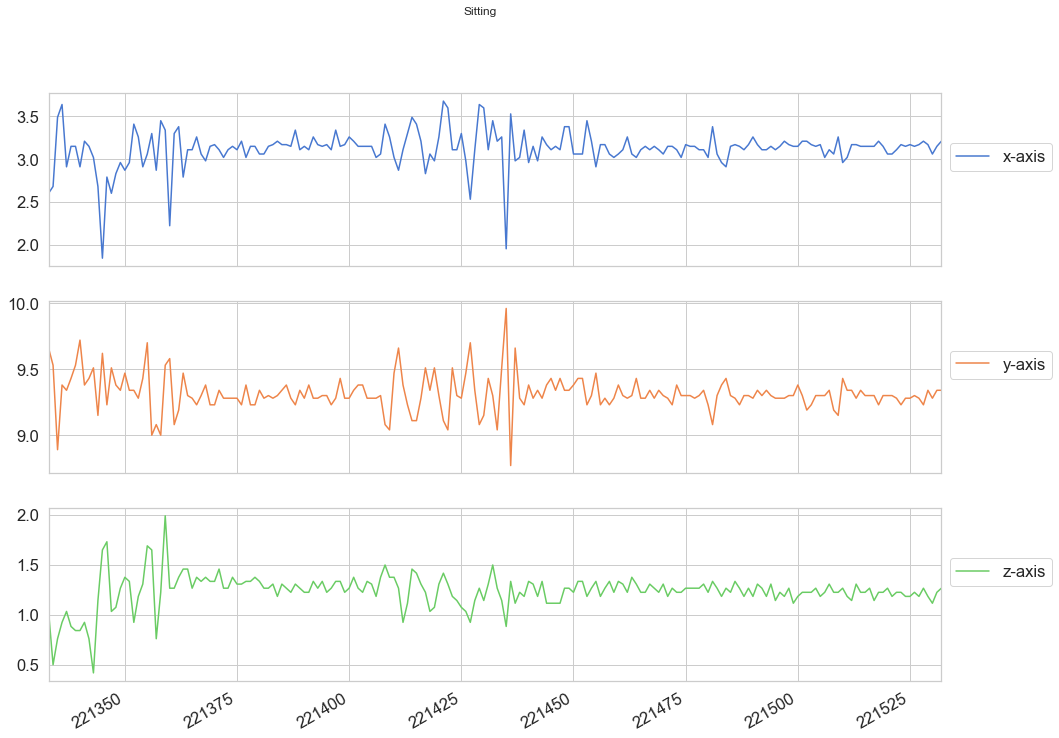

In [5]:
def plot_activity(activity, df, seq_size=200):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:seq_size]
    axis = data.plot(subplots=True, figsize=(16, 12), title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

plot_activity("Sitting", df, seq_size=seq_size)

### Prepara dataset for Training

In [6]:
step = 20
segments = []
labels = []
for i in range(0, len(df) - seq_size, step):
    xs = df['x-axis'].values[i: i + seq_size]
    ys = df['y-axis'].values[i: i + seq_size]
    zs = df['z-axis'].values[i: i + seq_size]
    label = stats.mode(df['activity'][i: i + seq_size])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

/Users/leonardo_a/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [7]:
# Reshape segments
segments = np.asarray(segments, dtype= np.float32).reshape(-1, seq_size, N_FEATURES)
# input format should be (seq_len, batch, input_size)
#segments = np.transpose(segments, (1, 0, 2))
# Make one hot encoding
labels = np.asarray(pd.get_dummies(labels), dtype = np.long)

### Check Nan on Numpy arrays

In [8]:
check_segments = np.isnan(segments)
check_labels = np.isnan(labels)
print('Nan in segments:', np.count_nonzero(check_segments))
print('Nan in labels:', np.count_nonzero(check_segments))

Nan in segments: 0
Nan in labels: 0


### Split train and Validation

In [9]:
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=42)

### Create Torch datasets

In [10]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

dataset_train = utils.TensorDataset(X_train,y_train)
dataset_test = utils.TensorDataset(X_test,y_test)
train_loader = utils.DataLoader(dataset_train, batch_size=BATCH_SIZE)
test_loader = utils.DataLoader(dataset_test, batch_size=BATCH_SIZE)

### Define Model
![alt text](imgs/stacked_lstm.png "Types")
This model will have:

* 2 stacked LSTM layers
* 1 FC layer with Relu Activation
* 1 SOFTMAX Layer

In [11]:
class ActionModel(nn.Module):
    def __init__(self, num_classes=6, input_dim=3, hidden_dim = 64, num_lstm_layers=2):
        super(ActionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_lstm_layers = num_lstm_layers
        # Create LSTM layer (input_size, size_hidden_features)
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=False, num_layers=num_lstm_layers)
        # Create FC layer (input_size, output_size)
        self.linear = torch.nn.Linear(hidden_dim, num_classes)
        # Create Softmax Layer
        self.softmax = torch.nn.functional.softmax

    def forward(self, input):
        
        # Run the LSTM layer with a batch of sample
        # input shape should be (seq_len, batch, input_size)
        input = input.permute(1, 0, 2)
        #print('Input:',input.size())
        lstm_out, lstm_hidden = self.lstm(input, self.initHidden(input.size()[1]))
        #output = [sent len, batch size, hid_dim]
        #hidden = [1, batch size, hid_dim]
        # Run the FC layer        
        # Should get last element from the lstm
        last_output = lstm_out[-1]
        #scores = F.relu(self.linear(lstm_hidden[0].squeeze(0)))
        scores = F.relu(self.linear(last_output))
        
        # Run softmax layer (Convert to probabilities)
        predictions = F.log_softmax(scores, dim=-1)        
        return predictions

    # Initialize hidden and cell state before each batch
    #h_0 of shape (num_layers * num_directions, batch, hidden_size)
    def initHidden(self, batch_size):
        return (torch.zeros(self.num_lstm_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_lstm_layers, batch_size, self.hidden_dim))


action_model = ActionModel(num_classes=num_classes, input_dim=3)

### Instantiate Loss and Optimizer

In [12]:
#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(action_model.parameters(), lr=0.01)

### Train

100%|██████████| 50/50 [2:20:27<00:00, 180.80s/it]  


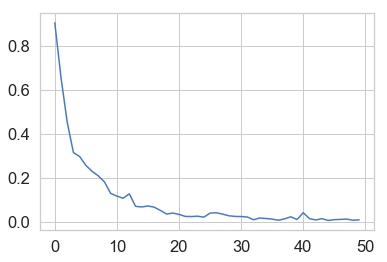

In [13]:
accuracies, max_accuracy = [], 0
all_losses = []
for x in trange(N_EPOCHS):
    #print('Epoch: {}'.format(x))
    for batch_idx, samples in enumerate(train_loader):
        # Get model inputs and labels
        X = samples[0]; Y = samples[1]
        Y_class = torch.max(Y, 1)[1]
        optimizer.zero_grad()
        predictions = action_model(X)
        
        # Calculate loss.
        loss = loss_fn(predictions, Y_class)
        #print('Loss: {:6.4f}'.format(loss.item()))
        # Backpropagate
        loss.backward()
        # Update weights
        optimizer.step()
    all_losses.append(loss.item())
    #print('Loss: {:6.4f}'.format(loss.item()))

# Plot loss graph
plt.figure()
plt.plot(all_losses)

### Validate

In [14]:
with torch.no_grad():
        matches, total = 0, 0
        for batch_idx, samples in enumerate(test_loader):
            # Get model inputs and labels
            X = samples[0]; Y = samples[1]
            Y_class = torch.max(Y, 1)[1]
            predictions = action_model(X)
            # Choose the letter with the maximum probability
            _, batch_out = predictions.max(dim=-1)
            # Remove fake dimension
            #batch_out = batch_out.squeeze(1)
            # Calculate accuracy
            matches += torch.eq(batch_out, Y_class).sum().item()
            total += torch.numel(batch_out)
        accuracy = matches / total
        print('Accuracy: {:4.2f}%'.format(accuracy * 100))

Accuracy: 98.62%


### Model with CONV1D

In [22]:
class ActionModel(nn.Module):
    def __init__(self, num_classes=6, input_dim=3, hidden_dim = 64, num_lstm_layers=2, conv_filters=32):
        super(ActionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_lstm_layers = num_lstm_layers
        
        self.conv1 = nn.Sequential(         
            nn.Conv1d(
                in_channels=input_dim,      #Inputs time series, with X, Y and Z
                out_channels=conv_filters,  #Some random number
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.Conv1d(
                in_channels=conv_filters,
                out_channels=conv_filters*2,
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),
        )
        
        self.fc_layer = nn.Sequential(
            nn.ReLU(),
            nn.Linear(conv_filters*2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )
        
        # Create LSTM layer (input_size, size_hidden_features)
        self.lstm = torch.nn.LSTM(hidden_dim, hidden_dim, batch_first=False, num_layers=num_lstm_layers)
        # Create FC layer (input_size, output_size)
        self.linear = torch.nn.Linear(hidden_dim, num_classes)
        # Create Softmax Layer
        self.softmax = torch.nn.functional.softmax

    def forward(self, input):
        # Run the CONV1D Layer
        input = input.permute(0, 2, 1)
        input = self.conv1(input)
        #print(input.size())
        
        # Run the LSTM layer with a batch of sample
        # input shape should be (seq_len, batch, input_size)
        input = input.permute(2, 0, 1)
        lstm_out, lstm_hidden = self.lstm(input, self.initHidden(input.size()[1]))
        
        #output = [sent len, batch size, hid_dim]
        #hidden = [1, batch size, hid_dim]
        # Run the FC layers        
        # Should get last element from the lstm (Many to one)
        last_output = lstm_out[-1]
        
        scores = self.fc_layer(last_output)
        
        logits = self.linear(scores)
        
        # Run softmax layer (Convert to probabilities)
        predictions = F.log_softmax(logits, dim=-1)        
        return predictions

    # Initialize hidden and cell state before each batch
    #h_0 of shape (num_layers * num_directions, batch, hidden_size)
    def initHidden(self, batch_size):
        return (torch.zeros(self.num_lstm_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_lstm_layers, batch_size, self.hidden_dim))


action_model = ActionModel(num_classes=num_classes, input_dim=3)

100%|██████████| 50/50 [4:31:58<00:00, 347.98s/it]  


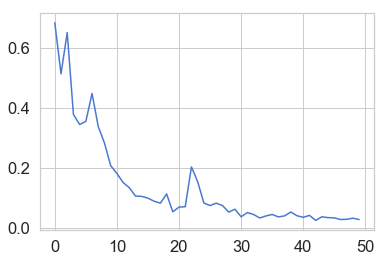

In [23]:
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(action_model.parameters(), lr=0.01)

accuracies, max_accuracy = [], 0
all_losses = []
for x in trange(N_EPOCHS):
    #print('Epoch: {}'.format(x))
    for batch_idx, samples in enumerate(train_loader):
        # Get model inputs and labels
        X = samples[0]; Y = samples[1]
        Y_class = torch.max(Y, 1)[1]
        optimizer.zero_grad()
        predictions = action_model(X)
        
        # Calculate loss.
        loss = loss_fn(predictions, Y_class)
        #print('Loss: {:6.4f}'.format(loss.item()))
        # Backpropagate
        loss.backward()
        # Update weights
        optimizer.step()
    all_losses.append(loss.item())
    #print('Loss: {:6.4f}'.format(loss.item()))

# Plot loss graph
plt.figure()
plt.plot(all_losses)

In [24]:
action_model.eval()
with torch.no_grad():
        matches, total = 0, 0
        for batch_idx, samples in enumerate(test_loader):
            # Get model inputs and labels
            X = samples[0]; Y = samples[1]
            Y_class = torch.max(Y, 1)[1]
            predictions = action_model(X)
            # Choose the letter with the maximum probability
            _, batch_out = predictions.max(dim=-1)
            # Remove fake dimension
            #batch_out = batch_out.squeeze(1)
            # Calculate accuracy
            matches += torch.eq(batch_out, Y_class).sum().item()
            total += torch.numel(batch_out)
        accuracy = matches / total
        print('Accuracy: {:4.2f}%'.format(accuracy * 100))

Accuracy: 98.70%
